# 1. Setup

Loading the libraries to use

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Input
from keras import layers
from keras import Model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 2. Data Description
The [dataset](https://medium.com/r/?url=http%3A%2F%2Farchive.ics.uci.edu%2Fml%2Fdatasets%2Fconnectionist%2Bbench%2B%28sonar%2C%2Bmines%2Bvs.%2Brocks%29) of this notebook contains patterns obtained by bouncing sonar signals off a metal cylinder and rocks at various angles and under various conditions. The transmitted sonar signal is a frequency-modulated chirp, rising in frequency. Each pattern is a set of 60 frequency bins scaled to a range from 0.0 to 1.0. Each number represents the energy within a particular frequency band, integrated over a certain period of time.

<AxesSubplot:>

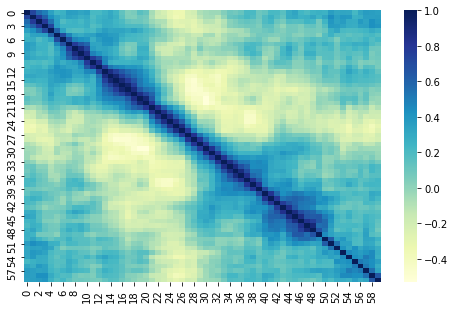

In [2]:
sonar = pd.read_csv('./sonar.all-data.csv', header=None)
sonar.head()
plt.figure(figsize=(8,5))
corr = sonar.corr()
sns.heatmap(corr, cmap="YlGnBu")

As it can be seen in the previous plot, there is some correlation between variables, this information can be compressed with the use of an autoencoder. Now let's make a sample representation of the power spectral density of two of the samples included in the dataset.

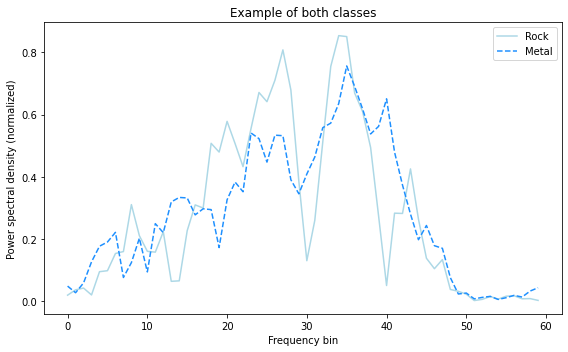

In [3]:
plt.figure(figsize=(8,5))
plt.plot(sonar[sonar[60] == 'R'].values[0][:-1], label='Rock', color='lightblue')
plt.plot(sonar[sonar[60] == 'M'].values[0][:-1], label='Metal', color='dodgerblue', linestyle='--')
plt.legend()
plt.title('Example of both classes')
plt.xlabel('Frequency bin')
plt.ylabel('Power spectral density (normalized)')
plt.tight_layout()
plt.show()

Let's take a look at the categories distribution

<Figure size 216x216 with 0 Axes>

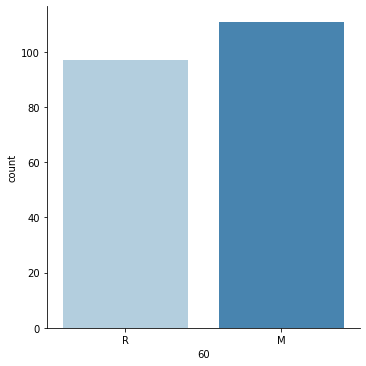

In [4]:
plt.figure(figsize=(3,3))
sns.catplot(x=sonar[60], kind='count', data=sonar, palette='Blues')

# 3. Data Splitting
Let's conform the inputs, target variable and split the test and train dataset for further processing.

In [5]:
X = sonar.loc[:,:59]
y = sonar.loc[:,60]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1)

n_inputs = X.shape[1]

# 4. Modelling the Autoencoder
Below is the model of the autoencoder that we'll use to compress the information from the dataset.

In [6]:
# Model AutoEncoder

inputs = Input(shape=(n_inputs,))
encoded = layers.Dense(n_inputs/2)(inputs)
encoded = BatchNormalization()(encoded)
encoded = LeakyReLU()(encoded)
encoded = layers.Dense(n_inputs/3)(encoded)
encoded = BatchNormalization()(encoded)
encoded = LeakyReLU()(encoded)

bottleneck = layers.Dense(n_inputs/6)(encoded)

decoded = layers.Dense(n_inputs/3)(bottleneck)
decoded = BatchNormalization()(decoded)
decoded = LeakyReLU()(decoded)
decoded = layers.Dense(n_inputs/2)(decoded)
decoded = BatchNormalization()(decoded)
decoded = LeakyReLU()(decoded)
outputs = layers.Dense(n_inputs, activation='sigmoid')(decoded)

To train the model we'll use a callback to stop the training in case the validation set (in this case training) can not achieve a further improvement. 

In [7]:
callback = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')

# Train the Model
history = model.fit(
    X_train, X_train, epochs=10000, batch_size=30,
    verbose=0, validation_data=(X_test,X_test))

# 5. Results Comparison
Let's see how the compressed representation of data compares to the non-compressed one, using a baseline model for comparison.

In [8]:
encoder = Model(inputs=inputs, outputs=bottleneck)
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)

acc = list()
training = [(X_train, X_test),
            (X_train_encode, X_test_encode)]

for x_train, x_test in training:
        model = LogisticRegression()
        model.fit(x_train, y_train)
        yhat = model.predict(x_test)

        acc.append(accuracy_score(y_test, yhat))
                   
print(f"60-dimensions model accuracy: {acc[0]}\n"
      f"10-dimensions model accuracy: {acc[1]}\n")

60-dimensions model accuracy: 0.7536231884057971
10-dimensions model accuracy: 0.7536231884057971



## 5.1 A note about training 
As can be seen, the prediction is the same using the compressed data and the non compressed one. Due to the stochastic initialization of neural networks, sometimes you have to repeat this process several times until a good performance is reached. 

For the following part where the encoder is applied to a neural net for classification purposes, a fine tuned encoder is used, which has been previoulsy trained (through several iterations) until an optimum value is reached. Results were always compared between the 60-dimensions and 10-dimensions accuracy with the baseline model.

# 6. Plotting the loss curve
Next, we'll plot the loss curves to see how the model improves through epochs. After experimenting with different epoch amounts, it's been determined that the best results needs a pretty high epoch number, as the used before. Notice that despite using the EarlyStopping, the model is not halting when the curve remains almost flat.

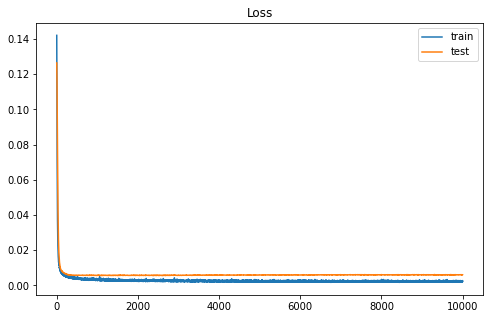

In [9]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('Loss')

plt.show()

Finally, the model is saved for later use, in the next [notebook](https://www.kaggle.com/augustodenevreze/mines-vs-rocks-encoder-deep-learning-clf).

In [10]:
encoder = Model(inputs=inputs, outputs=bottleneck)
# encoder.save('./encoder.h5')